### 1.加载人脸数据库

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

In [2]:
faces = fetch_lfw_people()

In [3]:
faces.data.shape

(13233, 2914)

In [4]:
# images是将我们的数据集以一个二维平面可视化的角度展现出来
# 62*47 = 2914
faces.images.shape

(13233, 62, 47)

In [5]:
# 随机获取36张脸
random_indexs = np.random.permutation(len(faces.data))
X = faces.data[random_indexs]
example_faces = X[:36,:]
example_faces.shape

(36, 2914)

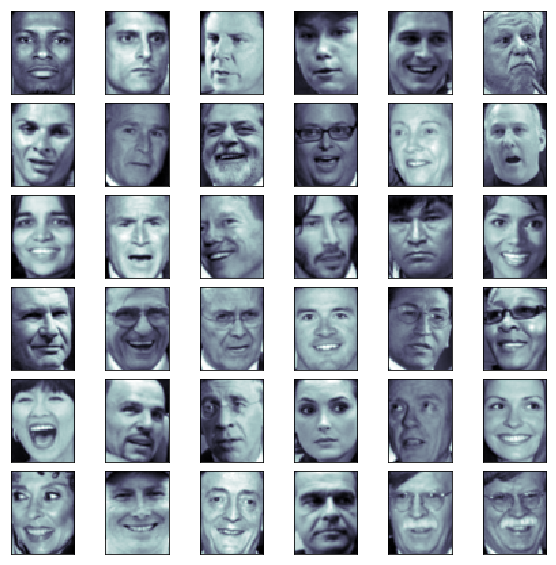

In [6]:
def plot_digits(data):
    fig,axes = plt.subplots(6,6,figsize=(10,10),
                           subplot_kw={'xticks':[],'yticks':[]},
                            gridspec_kw=dict(hspace=0.1,wspace=0.1))
    for i,ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(62,47),cmap='bone')
plot_digits(example_faces)

In [7]:
# 每张脸对应的人名
faces.target_names

array(['AJ Cook', 'AJ Lamas', 'Aaron Eckhart', ..., 'Zumrati Juma',
       'Zurab Tsereteli', 'Zydrunas Ilgauskas'], dtype='<U35')

In [8]:
# 说明一共包含5749个不同的人的脸
len(faces.target_names)

5749

### 2.特征脸

In [9]:
%%time
X,y = faces.data,faces.target
from sklearn.decomposition import PCA
# 使用随机的方式来求解出PCA
# 没有指定n_componets ，也就是说想求出所有的主成分
pca = PCA(svd_solver='randomized')
pca.fit(X)

CPU times: user 1min 56s, sys: 2.63 s, total: 1min 59s
Wall time: 30.6 s


In [10]:
# 一共2914个维度，所以求出了2914个主成分
pca.components_.shape

(2914, 2914)

#### 使用所有的主成分绘制特征脸，
> 可以看到排在前面的这些脸相应的比较笼统，排名第一的这张脸，告诉我们人脸大概就是这个位置，大概有这样一个轮廓
越往后，鼻子眼睛的信息就清晰了起来

通过求特征脸
- 一方面我们可以方便直观的看出在人脸识别的过程中我们是怎么看到每一张脸相应的特征的
- 另一方面，也可以看出来，其实每一张脸都是这些人脸的一个线性组合，而特征脸依据重要程度顺序的排在了这里

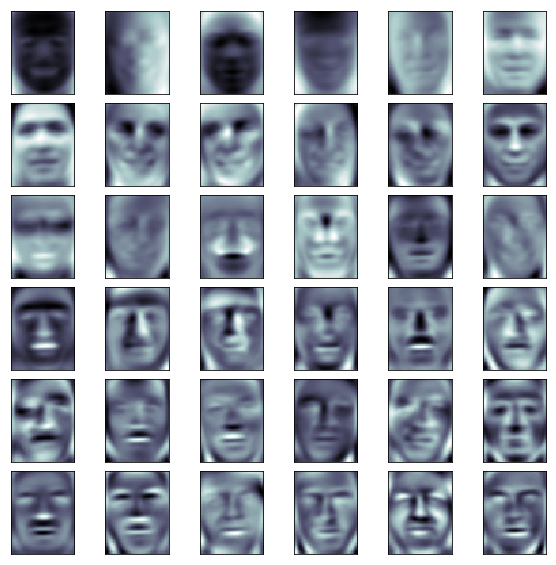

In [11]:
plot_digits(pca.components_[:36])

由于fetch_lfw_people这个库的人脸是分布不均匀的，有的人可能只有一张图片，有的人有几十张
通过这个方法我们可以取出至少有60张脸的人的数据
```faces2 = fetch_lfw_people(min_faces_per_person=60)```

#### 3.初识人脸识别

In [12]:
faces2 = fetch_lfw_people(min_faces_per_person=60)

In [13]:
faces2.data.shape

(1348, 2914)

In [14]:
faces2.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Junichiro Koizumi',
       'Tony Blair'], dtype='<U17')

In [15]:
X,y = faces2.data,faces2.target

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [18]:
from sklearn.decomposition import PCA
pca = PCA(0.9)
pca.fit(X_train)
X_train_reduction = pca.transform(X_train)
X_test_reduction = pca.transform(X_test)

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# 使用网格搜索
param_grid =[
    {
        'weights':['uniform'],
        'n_neighbors': [i for i in range(1,11)]
    },
    {
        'weights':['distance'],
        'n_neighbors': [i for i in range(1,11)],
        'p': [i for i in range(1,6)]
    }
]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf,param_grid)
# 调用fit方法执行网格搜索
%time
grid_search.fit(X_train_reduction,y_train)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'weights': ['uniform'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, {'weights': ['distance'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'p': [1, 2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
knn_clf = grid_search.best_estimator_

In [26]:
knn_clf.fit(X_train_reduction,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=1,
           weights='distance')

In [28]:
knn_clf.score(X_test_reduction,y_test)

0.655786350148368

In [34]:
knn_clf.predict([X_test_reduction[0]])

array([3])

In [35]:
pca.n_components_

81

In [38]:
y_name_test = faces2.target_names[y_test]

In [39]:
y_name_test

array(['George W Bush', 'George W Bush', 'Colin Powell', 'George W Bush',
       'George W Bush', 'Tony Blair', 'George W Bush', 'Colin Powell',
       'Donald Rumsfeld', 'Junichiro Koizumi', 'George W Bush',
       'Gerhard Schroeder', 'Colin Powell', 'Hugo Chavez', 'Ariel Sharon',
       'Colin Powell', 'Donald Rumsfeld', 'Junichiro Koizumi',
       'George W Bush', 'George W Bush', 'Junichiro Koizumi',
       'George W Bush', 'George W Bush', 'George W Bush',
       'Donald Rumsfeld', 'Gerhard Schroeder', 'Donald Rumsfeld',
       'Colin Powell', 'Hugo Chavez', 'Gerhard Schroeder',
       'Junichiro Koizumi', 'Ariel Sharon', 'Tony Blair', 'George W Bush',
       'Colin Powell', 'Tony Blair', 'Tony Blair', 'George W Bush',
       'George W Bush', 'Tony Blair', 'Tony Blair', 'George W Bush',
       'Colin Powell', 'George W Bush', 'George W Bush', 'Colin Powell',
       'George W Bush', 'Colin Powell', 'Ariel Sharon', 'George W Bush',
       'George W Bush', 'Colin Powell', 'Ariel Sha

In [40]:
y_test

array([3, 3, 1, 3, 3, 7, 3, 1, 2, 6, 3, 4, 1, 5, 0, 1, 2, 6, 3, 3, 6, 3,
       3, 3, 2, 4, 2, 1, 5, 4, 6, 0, 7, 3, 1, 7, 7, 3, 3, 7, 7, 3, 1, 3,
       3, 1, 3, 1, 0, 3, 3, 1, 0, 3, 6, 2, 0, 3, 3, 1, 1, 6, 4, 2, 1, 3,
       3, 3, 7, 7, 3, 3, 1, 1, 1, 1, 5, 1, 3, 3, 1, 6, 3, 3, 6, 3, 1, 5,
       3, 3, 1, 1, 1, 4, 3, 5, 3, 2, 4, 5, 1, 3, 0, 1, 3, 6, 4, 1, 3, 3,
       1, 7, 3, 2, 5, 4, 3, 3, 2, 3, 2, 1, 5, 7, 3, 6, 3, 2, 1, 1, 3, 5,
       5, 0, 4, 0, 2, 3, 4, 3, 3, 3, 3, 4, 2, 6, 7, 3, 2, 3, 3, 4, 2, 3,
       1, 3, 1, 0, 4, 5, 3, 3, 0, 3, 4, 3, 7, 3, 3, 1, 3, 1, 1, 3, 3, 7,
       3, 4, 6, 6, 3, 4, 3, 2, 3, 3, 3, 5, 2, 3, 3, 7, 1, 1, 2, 3, 2, 3,
       3, 7, 3, 7, 3, 6, 0, 1, 6, 3, 3, 3, 3, 0, 1, 4, 3, 3, 1, 3, 3, 3,
       6, 3, 3, 3, 1, 2, 3, 3, 5, 3, 1, 5, 2, 2, 3, 1, 5, 3, 4, 2, 7, 3,
       0, 1, 3, 3, 2, 5, 3, 3, 3, 1, 0, 1, 3, 2, 3, 0, 3, 3, 1, 3, 3, 1,
       3, 1, 2, 1, 1, 4, 6, 3, 3, 5, 0, 3, 1, 4, 1, 1, 3, 7, 3, 1, 3, 3,
       7, 1, 3, 3, 5, 1, 5, 3, 1, 3, 3, 1, 2, 3, 5,

In [41]:
faces2.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Junichiro Koizumi',
       'Tony Blair'], dtype='<U17')